# Klasifikace jako úloha lineárního programování

V této části si ukážeme, jak lze jednoduchý klasifikační úkol formulovat jako **úlohu lineárního programování (LP)**.

Budeme mít dvě třídy bodů v rovině:

- první třída $M_0$,
- druhá třída $M_1$,

a budeme hledat **separační křivku** $\varphi(x)$, která tyto dvě skupiny v grafu co nejlépe oddělí.

Pro názornost vezmeme skupinu lidí popsanou:

- hmotností $m$ (v kilogramech),
- výškou $h$ (v centimetrech),

a chceme je rozdělit do dvou tříd podle **BMI**:

$$
\mathrm{BMI} = \frac{m}{(h/100)^2}.
$$

Použijeme hranici $\mathrm{BMI}_{\max} = 24$.  
Pokud je $\mathrm{BMI} \le 24$, přiřadíme bod do třídy $M_0$, jinak do $M_1$.


In [ ]:
# Generování syntetických dat: výška, hmotnost, BMI, label

import numpy as np
import pandas as pd

rng = np.random.default_rng(42)  # deterministic randomness

def generate_data(
    N=200,
    max_bmi=24.0,
    m_mean=80.0,
    m_sigma=12.0,
    h_mean=180.0,
    h_sigma=11.0,
):
    """Generate synthetic dataset of people with weight, height, BMI and class label."""
    # Random weights and heights from normal distributions
    m = rng.normal(loc=m_mean, scale=m_sigma, size=N)  # weight [kg]
    h = rng.normal(loc=h_mean, scale=h_sigma, size=N)  # height [cm]

    # Basic clipping to avoid unrealistic values
    m[m < 40] = m_mean
    h[h < 140] = h_mean

    # Compute BMI (height converted to meters)
    bmi = m / (h / 100.0) ** 2

    # Labels: 1 if BMI > max_bmi, else 0
    labels = np.where(bmi > max_bmi, 1, 0)

    data = {
        "h": h,        # height in cm
        "m": m,        # weight in kg
        "bmi": bmi,
        "label": labels,
    }
    return pd.DataFrame(data)

data = generate_data()
data.head()


h          m        bmi  label
0  183.713320  83.656605  24.786713      1
1  195.482300  67.520191  17.669277      0
2  180.996434  89.005414  27.169171      1
3  187.083327  91.286777  26.081809      1
4  157.448107  56.587578  22.826862      0

Tabulka obsahuje:

- `h` – výšku v centimetrech,
- `m` – hmotnost v kilogramech,
- `bmi` – vypočtené BMI,
- `label` – třídu: 0 (BMI $\le 24$) nebo 1 (BMI $> 24$).

V grafu budeme používat:

- na ose $x$ výšku v metrech,
- na ose $y$ hmotnost v kilogramech,
- barvu bodu podle třídy.

Současně vykreslíme i **analytickou hranici** $\mathrm{BMI} = 24$:

$$
m = \mathrm{BMI}_{\max} \cdot \left(\frac{h}{100}\right)^2.
$$


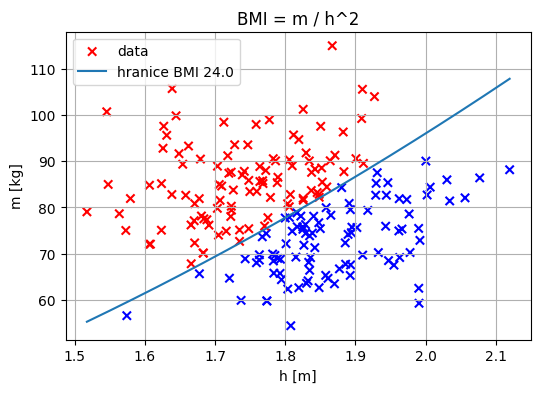

In [ ]:
# Vykreslení dat a analytické BMI hranice

import matplotlib.pyplot as plt

MAX_BMI = 24.0

h_m = data["h"].to_numpy() / 100.0  # convert to meters
m_vals = data["m"].to_numpy()
labels = data["label"].to_numpy()

# Prepare grid of heights for plotting the BMI boundary
h_grid = np.linspace(h_m.min(), h_m.max(), 200)
m_bmi_boundary = MAX_BMI * h_grid ** 2

plt.figure(figsize=(6, 4))
plt.title("BMI = m / h^2")

# Scatter plot: color by class
colors = np.where(labels == 1, "red", "blue")
plt.scatter(h_m, m_vals, c=colors, marker="x", label="data")

# BMI boundary curve
plt.plot(h_grid, m_bmi_boundary, label=f"hranice BMI {MAX_BMI}")

plt.xlabel("h [m]")
plt.ylabel("m [kg]")
plt.grid(True)
plt.legend()
plt.show()


## Matematický model klasifikace

Budeme hledat **separační křivku** $\varphi(x)$ ve tvaru lineární kombinace bázických funkcí $\theta_k(x)$:

$$
\varphi(\beta_0,\dots,\beta_K; x) = \sum_{k=0}^{K} \beta_k \,\theta_k(x).
$$

Volba bázických funkcí je na nás, podobně jako v regresi.  
Pro jednoduchost vezmeme **parabolu** v proměnné $x = h$ (výška v metrech):

$$
\varphi(x) = \beta_0 + \beta_1 x + \beta_2 x^2,
$$

tedy

$$
\theta_0(x) = 1,\quad
\theta_1(x) = x,\quad
\theta_2(x) = x^2.
$$

Označme:

- $M_0$ – body s labelem 0 (BMI $\le \mathrm{BMI}_{\max}$),
- $M_1$ – body s labelem 1 (BMI $> \mathrm{BMI}_{\max}$).

Chceme, aby

- body z $M_0$ ležely **pod** křivkou $\varphi$,
- body z $M_1$ ležely **nad** křivkou $\varphi$,

a navíc mezi nimi byla určitá **rezerva** (margin) $\delta > 0$.

Formulujeme proto:

$$
\begin{aligned}
\max\;& z = \delta \\
\text{za podmínek:}\quad
& \varphi(x_i) - \delta \ge y_i, \quad (x_i, y_i) \in M_0,\\
& \varphi(x_i) + \delta \le y_i, \quad (x_i, y_i) \in M_1,\\
& \delta \ge 0,\quad \beta_0,\dots,\beta_K \in \mathbb{R}.
\end{aligned}
$$

Interpretace:

- Pro body třídy $M_0$ je svislá vzdálenost křivky nad bodem alespoň $\delta$.
- Pro body třídy $M_1$ je svislá vzdálenost křivky pod bodem alespoň $\delta$.

Maximalizací $\delta$ hledáme křivku, která třídy co nejlépe odděluje.


In [ ]:
# Sestavení LP modelu pro separační křivku

from pulp import LpProblem, LpMaximize, LpVariable, lpSum, LpStatus, value

# Prepare numeric data
x = data["h"].to_numpy(dtype=float) / 100.0  # height in meters
y = data["m"].to_numpy(dtype=float)          # weight in kg
labels = data["label"].to_numpy(dtype=int)
n = len(data)

# Polynomial degree (2 -> beta_0, beta_1, beta_2)
degree = 2
num_beta = degree + 1

# Build Theta matrix with basis functions theta_k(x) = x^k
Theta = np.vstack([x ** k for k in range(num_beta)]).T
print("Theta shape:", Theta.shape)  # (n, 3) for quadratic model

# Create LP model (maximization)
model = LpProblem(name="Separation", sense=LpMaximize)

# Margin variable delta >= 0
delta = LpVariable(name="delta", lowBound=0)

# Coefficients beta_k are free (can be any real number)
beta = LpVariable.dicts("beta", range(num_beta), lowBound=None)

# Objective: maximize the margin delta
model += delta, "Margin"

# Constraints: points of class 0 below curve, class 1 above curve
for i in range(n):
    # Linear prediction at x_i: phi(x_i) = Theta_i * beta
    prediction = lpSum(beta[k] * Theta[i, k] for k in range(num_beta))

    if labels[i] == 0:
        # Class 0: phi(x_i) - delta >= y_i
        model += prediction - delta >= y[i], f"Constr_M0_{i}"
    else:
        # Class 1: phi(x_i) + delta <= y_i
        model += prediction + delta <= y[i], f"Constr_M1_{i}"

print(model)


Theta shape: (200, 3)
Separation:
MAXIMIZE
1*delta + 0
SUBJECT TO
Constr_M1_0: beta_0 + 1.83713320037 beta_1 + 3.37505839589 beta_2 + delta
 <= 83.6566049571

Constr_M0_1: beta_0 + 1.95482300474 beta_1 + 3.82133297988 beta_2 - delta
 >= 67.5201907251

Constr_M1_2: beta_0 + 1.80996433976 beta_1 + 3.2759709112 beta_2 + delta
 <= 89.0054143497

Constr_M1_3: beta_0 + 1.87083326726 beta_1 + 3.50001711389 beta_2 + delta
 <= 91.2867765967

Constr_M0_4: beta_0 + 1.57448106889 beta_1 + 2.47899063628 beta_2 - delta
 >= 56.5875777362

Constr_M0_5: beta_0 + 1.79464097579 beta_1 + 3.22073623198 beta_2 - delta
 >= 64.3738459177

Constr_M1_6: beta_0 + 1.70724467027 beta_1 + 2.91468436416 beta_2 + delta
 <= 81.534084838

Constr_M1_7: beta_0 + 1.66593056335 beta_1 + 2.77532464191 beta_2 + delta
 <= 76.2050888919

Constr_M1_8: beta_0 + 1.70340323964 beta_1 + 2.90158259681 beta_2 + delta
 <= 79.7983861099

Constr_M0_9: beta_0 + 1.76324642152 beta_1 + 3.10903794301 beta_2 - delta
 >= 69.7634728691

Constr

## Řešení modelu

Nyní LP model vyřešíme:

- ověříme status řešiče,
- zjistíme maximální dosažitelnou hodnotu $\delta$,
- vypíšeme koeficienty separační křivky $\beta_0,\beta_1,\beta_2$.


In [ ]:
# Solution of the separation LP model

result_status = model.solve()

print(f"Hotovo: {result_status}")
print(f"Závěr: {model.status}, {LpStatus[model.status]}")
print(f"Optimum (delta): {value(model.objective)}\n")

for v in model.variables():
    print(f"{v.name}: {v.value()}")

# Extract beta coefficients into a NumPy array for plotting
beta_sep = np.array([beta[k].value() for k in range(num_beta)], dtype=float)
print("\nKoeficienty separační funkce:", beta_sep)


Hotovo: 1
Závěr: 1, Optimal
Optimum (delta): 0.25005914

beta_0: -150.76117
beta_1: 170.35241
beta_2: -24.04924
delta: 0.25005914

Koeficienty separační funkce: [-150.76117  170.35241  -24.04924]


## Vizualizace separační křivky

Pomocí nalezených koeficientů $\beta$ vykreslíme separační křivku

$$
\varphi(x) = \beta_0 + \beta_1 x + \beta_2 x^2
$$

a porovnáme ji s analytickou hranicí $\mathrm{BMI} = 24$.

V grafu uvidíme:

- body dvou tříd (červená vs. modrá),
- analytickou BMI křivku,
- námi nalezenou separační křivku $\varphi$.


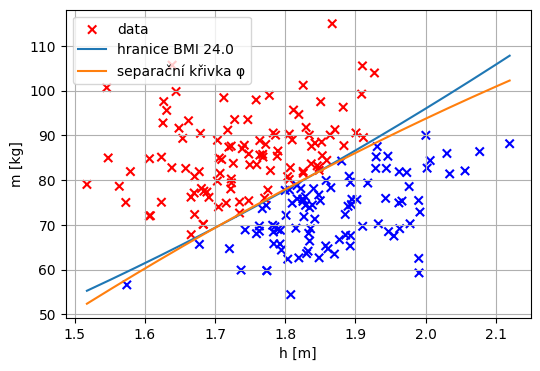

In [ ]:
# Plot data, BMI boundary, and the learned separation curve

# Height grid for curves
h_grid = np.linspace(x.min(), x.max(), 300)

# Analytic BMI boundary
m_bmi_boundary = MAX_BMI * h_grid ** 2

# Learned separation curve phi(x) = beta_0 + beta_1 x + beta_2 x^2
phi_grid = beta_sep[0] + beta_sep[1] * h_grid + beta_sep[2] * h_grid ** 2

plt.figure(figsize=(6, 4))

# Scatter of data by class
colors = np.where(labels == 1, "red", "blue")
plt.scatter(x, y, c=colors, marker="x", label="data")

# Curves
plt.plot(h_grid, m_bmi_boundary, label=f"hranice BMI {MAX_BMI}")
plt.plot(h_grid, phi_grid, label="separační křivka φ")

plt.xlabel("h [m]")
plt.ylabel("m [kg]")
plt.grid(True)
plt.legend()
plt.show()


## Srovnání tří klasifikátorů (LP vs. logistická regrese vs. SVM)
Srovnáme tři modely. LP, logistickou regresi a Support Vector Machine. Pokusíme se to udělat co nejvíce fér.

1. Znovu vygenerujeme data pomocí `generate_data` (stejně jako dříve).
2. Rozdělíme je na **trénovací** a **testovací** část (70 % / 30 %).
3. Všechny modely budou trénované pouze na trénovacích datech.
4. Hodnotit budeme **jen na testovací množině**.
5. Pro logistickou regresi a SVM použijeme standardizaci vstupů  
   a u SVM navíc jednoduchý **grid search** přes parametry $C$ a $\gamma$.

Modely:

- **LP klasifikátor** – separační parabola
  $$\varphi(h) = \beta_0 + \beta_1 h + \beta_2 h^2,$$
- **logistická regrese** – lineární hranice v prostoru $(h,m)$,
- **SVM s RBF jádrem** – nelineární hranice učená z dat.

Výsledkem bude srovnání trénovací a testovací přesnosti všech tří.


In [ ]:
# Spravedlivý experiment: LP vs. logistická regrese vs. SVM

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

!pip install scikit-learn

# --- 1) Vygenerujeme nová data ---
N = 300  # více bodů pro robustnější srovnání
MAX_BMI = 24.0

data_all = generate_data(N=N, max_bmi=MAX_BMI)  # používá funkci z předchozí části

# Vstupní vektory: (h v metrech, m v kg)
X_all = np.column_stack([
    data_all["h"].to_numpy(dtype=float) / 100.0,  # výška v metrech
    data_all["m"].to_numpy(dtype=float),          # hmotnost v kg
])
y_all = data_all["label"].to_numpy(dtype=int)

# --- 2) Train / test split  ---
idx = np.arange(len(data_all))
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_all,
    y_all,
    idx,
    test_size=0.3,
    random_state=0,
    stratify=y_all,
)

data_train = data_all.iloc[idx_train].reset_index(drop=True)
data_test = data_all.iloc[idx_test].reset_index(drop=True)

print("Počty bodů podle tříd (train):")
print(pd.Series(y_train).value_counts().rename("count"))

print("\nPočty bodů podle tříd (test):")
print(pd.Series(y_test).value_counts().rename("count"))


Počty bodů podle tříd (train):
1    109
0    101
Name: count, dtype: int64

Počty bodů podle tříd (test):
1    46
0    44
Name: count, dtype: int64


### LP klasifikátor – na trénovacích datech

LP model dostane **stejná trénovací data** jako ostatní:

- používáme jen trénovací část `data_train`,
- separační křivka je opět parabola
  $$\varphi(h) = \beta_0 + \beta_1 h + \beta_2 h^2,$$
- třída 0 musí ležet pod křivkou, třída 1 nad křivkou,
- maximalizujeme margin $\delta$.

Získanou křivku použijeme k predikci na **trénovacích i testovacích** datech.


In [ ]:
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, LpStatus, value

# --- 3) LP klasifikátor na trénovacích datech ---

# Připravíme si výšku v metrech a hmotnost v kg pro train/test
x_tr = data_train["h"].to_numpy(dtype=float) / 100.0
m_tr = data_train["m"].to_numpy(dtype=float)
labels_tr = data_train["label"].to_numpy(dtype=int)

x_te = data_test["h"].to_numpy(dtype=float) / 100.0
m_te = data_test["m"].to_numpy(dtype=float)
labels_te = data_test["label"].to_numpy(dtype=int)

# Polynom 2. stupně -> beta_0, beta_1, beta_2
degree = 2
num_beta = degree + 1

Theta_tr = np.vstack([x_tr ** k for k in range(num_beta)]).T

# LP model
model = LpProblem(name="Separation_fair", sense=LpMaximize)

delta = LpVariable(name="delta", lowBound=0)
beta = LpVariable.dicts("beta", range(num_beta), lowBound=None)

# Maximalizujeme margin delta
model += delta, "Margin"

# Omezení: body třídy 0 pod křivkou, třídy 1 nad křivkou
for i in range(len(data_train)):
    prediction = lpSum(beta[k] * Theta_tr[i, k] for k in range(num_beta))
    if labels_tr[i] == 0:
        model += prediction - delta >= m_tr[i], f"M0_{i}"
    else:
        model += prediction + delta <= m_tr[i], f"M1_{i}"

result_status = model.solve()
print("Status LP řešiče:", LpStatus[model.status])
print("Optimální delta:", value(delta))

beta_sep = np.array([beta[k].value() for k in range(num_beta)], dtype=float)
print("Koeficienty separační paraboly (beta):", beta_sep)

# Funkce pro LP predikci
def lp_predict(h_meters: np.ndarray, m_kg: np.ndarray, beta_vec: np.ndarray) -> np.ndarray:
    """Return class predictions (0/1) based on LP separation curve."""
    phi = beta_vec[0] + beta_vec[1] * h_meters + beta_vec[2] * h_meters ** 2
    return (m_kg >= phi).astype(int)

# Predikce na train/test
y_pred_lp_train = lp_predict(x_tr, m_tr, beta_sep)
y_pred_lp_test = lp_predict(x_te, m_te, beta_sep)

acc_lp_train = (y_pred_lp_train == labels_tr).mean()
acc_lp_test = (y_pred_lp_test == labels_te).mean()

print(f"\nPřesnost LP klasifikátoru - train: {acc_lp_train:.3f}, test: {acc_lp_test:.3f}")


Status LP řešiče: Optimal
Optimální delta: 0.18872627
Koeficienty separační paraboly (beta): [-256.16036   286.13401   -55.844429]

Přesnost LP klasifikátoru - train: 1.000, test: 0.978


### Logistická regrese a SVM s férovým nastavením

Teď stejné trénovací/testovací množiny použijeme pro dva klasické modely:

- **Logistická regrese** – lineární hranice v $(h,m)$,  
- **SVM s RBF jádrem** – nelineární hranice.

Pro oba modely:

1. Standardizujeme vstupy $(h,m)$ pomocí `StandardScaler`.
2. Logistická regrese běží s defaultním nastavením.
3. U SVM uděláme malý **grid search** přes parametry:

   - $C \in \{0.1, 1, 10, 100\}$,
   - $\gamma \in \{0.01, 0.1, 1, 5\}$,
   - jádro `rbf`.

Hledáme parametry, které maximalizují přesnost na trénovacím setu pomocí 5-fold cross-validation.


In [ ]:
# --- 4) Logistická regrese a SVM s RBF jádrem ---

# Standardizace vstupů
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistická regrese
log_clf = LogisticRegression()
log_clf.fit(X_train_scaled, y_train)

acc_log_train = log_clf.score(X_train_scaled, y_train)
acc_log_test = log_clf.score(X_test_scaled, y_test)

# SVM + grid search
param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": [0.01, 0.1, 1, 5],
    "kernel": ["rbf"],
}
svm = SVC()
grid = GridSearchCV(svm, param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

svm_best = grid.best_estimator_
acc_svm_train = svm_best.score(X_train_scaled, y_train)
acc_svm_test = svm_best.score(X_test_scaled, y_test)

print(f"Přesnost logistické regrese - train: {acc_log_train:.3f}, test: {acc_log_test:.3f}")
print(f"Přesnost SVM (RBF, best)      - train: {acc_svm_train:.3f}, test: {acc_svm_test:.3f}")
print("Nejlepší parametry SVM:", grid.best_params_)


Přesnost logistické regrese - train: 0.995, test: 1.000
Přesnost SVM (RBF, best)      - train: 0.981, test: 0.967
Nejlepší parametry SVM: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


### Shrnutí výsledků

Nyní si výsledky všech tří modelů přehledně zobrazíme v malé tabulce.

Čísla se mohou při každém spuštění mírně lišit (náhodné generování dat, train/test split),  
ale typický obrázek je:

- LP separátor už **nemá triviálně 100 %** – trénuje se jen na části dat a generalizuje na zbytek.
- Logistická regrese tvoří „nejlepší možnou“ **přímku** v prostoru $(h,m)$.
- SVM s RBF jádrem má dostatečnou flexibilitu, aby se k nelineární hranici velmi dobře přizpůsobilo.


In [ ]:
# Přehledná tabulka přesností

results = pd.DataFrame(
    {
        "model": ["LP (parabola)", "Logistická regrese", "SVM (RBF, best)"],
        "train_accuracy": [acc_lp_train, acc_log_train, acc_svm_train],
        "test_accuracy": [acc_lp_test, acc_log_test, acc_svm_test],
    }
)
results


model  train_accuracy  test_accuracy
0       LP (parabola)        1.000000       0.977778
1  Logistická regrese        0.995238       1.000000
2     SVM (RBF, best)        0.980952       0.966667

### Vizualizace rozhodovacích hranic na testovacích datech

Pro lepší intuici vykreslíme do jednoho grafu:

- testovací body (skutečné třídy),
- LP separační parabolu,
- rozhodovací hranici logistické regrese,
- rozhodovací hranici SVM.

Hranice logistické regrese i SVM určíme jako **konturu rozhodovací funkce**  
`decision_function(...) = 0` v původním prostoru $(h,m)$.


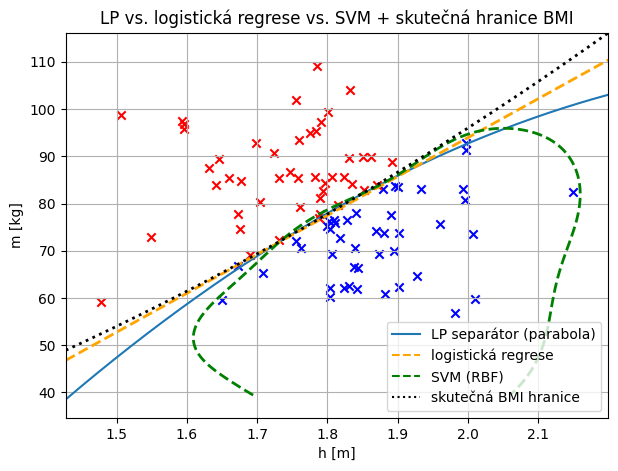

In [ ]:
# --- 5) Společná vizualizace všech tří modelů + skutečné hranice BMI ---

# Grid v prostoru (h,m)
h_min, h_max = X_all[:, 0].min() - 0.05, X_all[:, 0].max() + 0.05
m_min, m_max = X_all[:, 1].min() - 5.0, X_all[:, 1].max() + 5.0

xx, yy = np.meshgrid(
    np.linspace(h_min, h_max, 300),
    np.linspace(m_min, m_max, 300),
)
grid = np.c_[xx.ravel(), yy.ravel()]
grid_scaled = scaler.transform(grid)

# Rozhodovací funkce pro logistiku a SVM
Z_log = log_clf.decision_function(grid_scaled).reshape(xx.shape)
Z_svm = svm_best.decision_function(grid_scaled).reshape(xx.shape)

# LP separační parabola v rozsahu výšek
h_grid = np.linspace(h_min, h_max, 300)
phi_grid = beta_sep[0] + beta_sep[1] * h_grid + beta_sep[2] * h_grid**2

# **Skutečná analytická BMI hranice**
real_boundary = MAX_BMI * h_grid**2

plt.figure(figsize=(7, 5))

# Testovací data
plt.scatter(
    X_test[y_test == 0, 0],
    X_test[y_test == 0, 1],
    c="blue",
    marker="x",
    label="třída 0 (test)",
)
plt.scatter(
    X_test[y_test == 1, 0],
    X_test[y_test == 1, 1],
    c="red",
    marker="x",
    label="třída 1 (test)",
)

# LP separátor
plt.plot(h_grid, phi_grid, color="tab:blue", label="LP separátor (parabola)")

# Logistická regrese – hranice rozhodovací funkce = 0
plt.contour(
    xx,
    yy,
    Z_log,
    levels=[0],
    colors="orange",
    linestyles="--",
    linewidths=2,
)

# SVM – hranice rozhodovací funkce = 0
plt.contour(
    xx,
    yy,
    Z_svm,
    levels=[0],
    colors="green",
    linestyles="dashed",
    linewidths=2,
)

# *** Skutečná analytická hranice BMI ***
plt.plot(
    h_grid,
    real_boundary,
    color="black",
    linestyle=":",
    linewidth=2,
    label=f"skutečná BMI hranice ({MAX_BMI})",
)

plt.xlabel("h [m]")
plt.ylabel("m [kg]")
plt.title("LP vs. logistická regrese vs. SVM + skutečná hranice BMI")
plt.grid(True)

# Legend (proxy-based)
import matplotlib.lines as mlines
lp_proxy  = mlines.Line2D([], [], color="tab:blue", label="LP separátor (parabola)")
log_proxy = mlines.Line2D([], [], color="orange", linestyle="--", label="logistická regrese")
svm_proxy = mlines.Line2D([], [], color="green", linestyle="dashed", label="SVM (RBF)")
real_proxy = mlines.Line2D([], [], color="black", linestyle=":", label="skutečná BMI hranice")

plt.legend(handles=[lp_proxy, log_proxy, svm_proxy, real_proxy])

plt.show()


### Co z toho plyne?

- **LP klasifikátor** už není „triviálně stoprocentní“ jako zkraje úlohy – nyní učí se pouze z části dat  
  a jeho parabola je kompromisem mezi body obou tříd. Na testovacích datech
  se typicky pohybuje někde kolem $\approx 90$–$98$ % přesnosti (podle konkrétní realizace dat).

- **Logistická regrese** je lineární model v prostoru $(h,m)$, přesto si vede překvapivě dobře,
  protože reálné rozložení dat není extrémně nelineární.

- **SVM s RBF jádrem** po jednoduchém ladění parametrů $C$ a $\gamma$ často dosahuje  podobné nebo o něco lepší testovací přesnosti než LP i logistická regrese.
